### Model Governance Notebook for models with and without the GLLD feature - OOS
with and without `giact_last_link_date`

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../..')
import warnings
warnings.filterwarnings(action='ignore')
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

from src.utils import scale_scores
from rdsutils.post_implementation_testing import plot_score_dist, get_psi, get_overlap_and_diff
from rdsutils.post_implementation_testing import plot_difference, get_combined_dfs, get_feature_comparison_report

In [2]:
with open('../../models/customer_risk_target_from_gitlab.pkl', 'rb') as f:
    model_w_glld = pickle.load(f)
    
with open('../../models/customer_risk_target_no_giact_time_since_last_link.pkl', 'rb') as f:
    model_wo_glld = pickle.load(f)

### Data Processing

In [3]:
from collections import defaultdict

def encode_defaults(df, default_values):
    """Replace default values with NaN, int encode them"""
    default_encoded_cols = []
    for k, (v, encode) in default_values.items():
        cname = k + '_default_encoded'

        if isinstance(v, pd.Interval):
            is_default = ~df[k].between(v.left, v.right) & ~df[k].isna()
        elif isinstance(v, list):
            is_default = df[k].isin(k)
        else:
            raise RuntimeError('Data type {} not supported'.format(str(type(v))))
        
        if ~is_default.isna().all():
            if encode:
                default_encoded_cols.append(cname)
                df.loc[is_default, cname] = is_default * df[k]
            df.loc[is_default, k] = np.nan #set default values to NaN
        
    return df, default_encoded_cols


cols_raw = ['first_deposit_amount', 'vantage_score', 'bcc7120', 'email_risk_score', 
            'fraud_score_2', 'name_email_correlation', 'transaction_as_pct_of_balance', 
            'mean_account_balance_30d', 'phone_risk_score', 'giact_time_since_last_link', 
            'name_address_correlation', 'all8220', 'lag_acc_open_first_transaction', 
            'dollar_val_dd', 'all7120', 'sum_deposits_10d', 'nr_past_transactions', 
            'total_tradelines_open', 'education_loan_amount', 'address_risk_score',
            'iqt9415', 'max_withdrawals_30d', 'iln5520', 'max_deposits_30d', 
            'pct_returned_deposits', 'giact_nr_decline', 'nr_direct_deposits', 
            'time_since_last_transaction', 'bal_ratio', 'name_phone_correlation', 
            'giact_nr_other', 'dollar_val_returns', 'nr_trans_ratio', 'iqt9413', 
            'dollar_val_returns_3d', 'nr_returns_30d', 'credit_card_loan_amount',
            'fraud_score_1', 'age_money_account']

cols_raw_ni = ['transaction_code']

cols_encoded = ['transaction_code_encoded', 'all7120_default_encoded', 'bcc7120_default_encoded']

features = cols_raw + cols_encoded

default_values = {
    'vantage_score': [pd.Interval(300, 850), False],
    'all7120': [pd.Interval(0, 990), True],
    'all8220': [pd.Interval(0, 9990), False],
    'bcc7120': [pd.Interval(0, 990), True],
    'iln5520': [pd.Interval(0, 999999990), False],
    'iqt9413': [pd.Interval(0, 90), False]
}

def preprocess(df):
    """
    Code to preprocess model.
    """
    # mapping from transaction code to integer
    tcode_map = defaultdict(int,
                            {'POSDW': 1,
                             'ACHDD': 2,
                             'ACHDWIN': 3,
                             'ACHDDIN': 4,
                             'ACHDW': 5,
                             'ACHINDD': 6,
                             'DDATMREFUND': 7,
                             'DWATM': 8,
                             'DDRAFNEW':9,
                             'DDCK': 10})

    df['transaction_code_encoded'] = df['transaction_code'].map(tcode_map)
    
    # clip to handle infinite values and outliers
    df['transaction_as_pct_of_balance'] = df['transaction_as_pct_of_balance'].clip(-750, 750)
    df['bal_ratio'] = df['bal_ratio'].clip(-750, 750)
    df['pct_returned_deposits'] = df['pct_returned_deposits'].clip(0, 100)

    # fill na here with 0, can't be NaN just indicates lack of data
    df['transaction_as_pct_of_balance'] = df['transaction_as_pct_of_balance'].fillna(0)
    df['max_withdrawals_30d'] = df['max_withdrawals_30d'].fillna(0)
    df['max_deposits_30d'] = df['max_deposits_30d'].fillna(0)
    df['pct_returned_deposits'] = df['pct_returned_deposits'].fillna(0)
    df['bal_ratio'] = df['bal_ratio'].fillna(0)
    df['sum_deposits_10d'] = df['sum_deposits_10d'].fillna(0)
    df['mean_account_balance_30d'] = df['mean_account_balance_30d'].fillna(0)
    df['dollar_val_dd'] = df['dollar_val_dd'].fillna(0) 
    df['nr_direct_deposits'] = df['nr_direct_deposits'].fillna(0)
    df['nr_past_transactions'] = df['nr_past_transactions'].fillna(0)
    df['dollar_val_returns'] = df['dollar_val_returns'].fillna(0)
    df['dollar_val_returns_3d'] = df['dollar_val_returns_3d'].fillna(0)
    df['nr_returns_30d'] = df['nr_returns_30d'].fillna(0)

    # fill na here with -1 indicating that this is the first ever transaction/giact never linked
    df['time_since_last_transaction'] = df['time_since_last_transaction'].fillna(-1)
    df['giact_time_since_last_link'] = df['giact_time_since_last_link'].fillna(-1)
    df['giact_nr_decline'] = df['giact_nr_decline'].fillna(-1)
    df['giact_nr_other'] = df['giact_nr_other'].fillna(-1)
    df['nr_trans_ratio'] = df['nr_trans_ratio'].fillna(-1)
    df['first_deposit_amount'] = df['first_deposit_amount'].fillna(-1)
    df['lag_acc_open_first_transaction'] = df['lag_acc_open_first_transaction'].fillna(-1)
    
    df, _ = encode_defaults(df, default_values)
    
    df['all7120_default_encoded'] = df['all7120_default_encoded'].fillna(-1)
    df['bcc7120_default_encoded'] = df['bcc7120_default_encoded'].fillna(-1)
    
    return df

## OOS Data
---

In [4]:
modeling_df = pd.read_feather('../../artifacts/modeling_df_final_with_oof_preds_replication.feather')
modeling_df = preprocess(modeling_df)

# OOS
data_object = pickle.load(open('../../artifacts/cv_objects_wo_glld.pkl', 'rb'))
modeling_df['pred_wo_glld'] = data_object['pred']
modeling_df['score_wo_glld'] = scale_scores(modeling_df['pred_wo_glld'])

data_object = pickle.load(open('../../artifacts/cv_objects_w_glld.pkl', 'rb'))
modeling_df['pred_w_glld'] = data_object['pred']
modeling_df['score_w_glld'] = scale_scores(modeling_df['pred_w_glld'])

# get fico
credit_df = pd.read_feather('../../data/processed/processed_1598941185/experian_credit_pull_1598941185.feather')
dmd = pd.read_feather('../../data/processed/processed_1598941185/user_metadata_dw_1598941185.feather')
credit_df = pd.merge(credit_df[['user_id', 'credit_pull_date', 'fico_score']], dmd[['user_id', 'borrower_id']], how='inner', on='user_id')

# sort
credit_df = credit_df.sort_values(by=['credit_pull_date'])
modeling_df = modeling_df.sort_values(by=['sample_date'])

# merge
modeling_df = pd.merge_asof(modeling_df, credit_df, left_on='sample_date', right_on='credit_pull_date', by='borrower_id')

# adjust fico
modeling_df['fico_adjusted'] = modeling_df['fico_score'] * np.where(modeling_df['fico_score'] > 850, 0, 1)
modeling_df['fico_adjusted_2'] = modeling_df['fico_adjusted'].replace(0, np.nan)

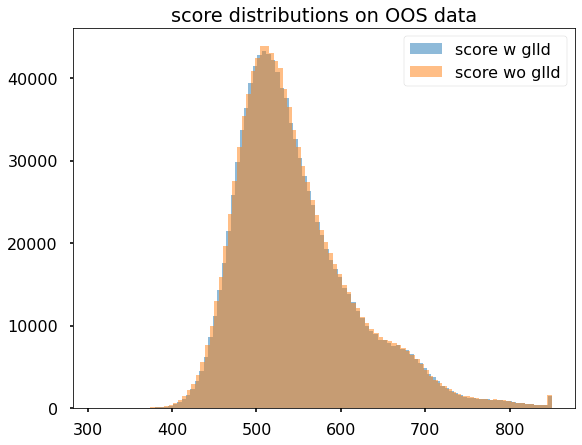

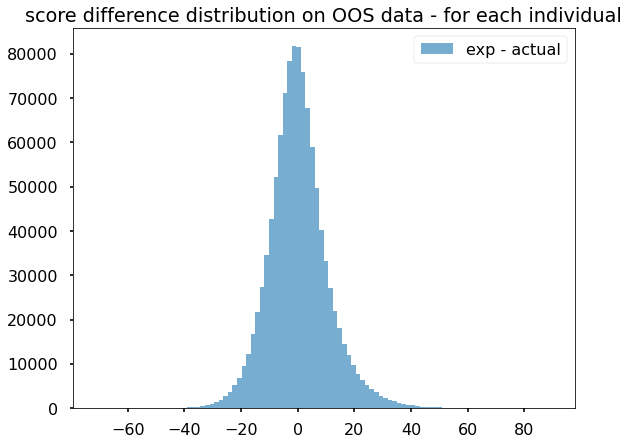

In [5]:
score_dist_plot = plot_score_dist(modeling_df.score_w_glld, 
                                  modeling_df.score_wo_glld, 
                                  bins=100, 
                                  dev_label='score w glld',
                                  prod_label='score wo glld',
                                  title='score distributions on OOS data')
score_diff_plot = plot_difference(modeling_df.score_w_glld, 
                                  modeling_df.score_wo_glld, bins=100, 
                                  title='score difference distribution on OOS data - for each individual')

In [6]:
score_diff_plot.savefig('../../artifacts/without-glld/comparison_score_stats/OOS/oos_score_diff_plot.png')
score_dist_plot.savefig('../../artifacts/without-glld/comparison_score_stats/OOS/oos_score_dist_plot.png')

### AUC and AP plots

In [10]:
from rdsutils.plot import plot_auc_curve_mult, plot_pr_curve_mult

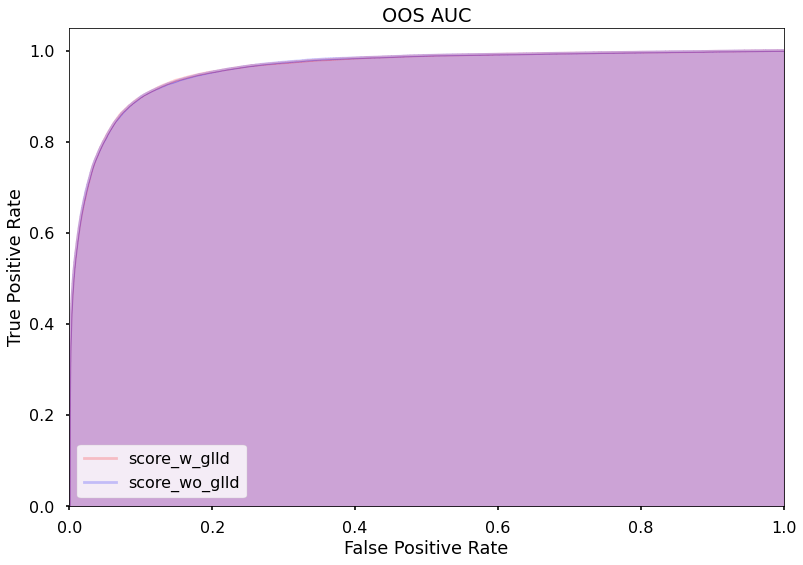

In [9]:
scores = [(modeling_df.score_w_glld, 'score_w_glld'), (modeling_df.score_wo_glld, 'score_wo_glld')]
plot_auc_curve_mult(modeling_df['target'], scores, 'OOS AUC', colors=['r', 'b'])

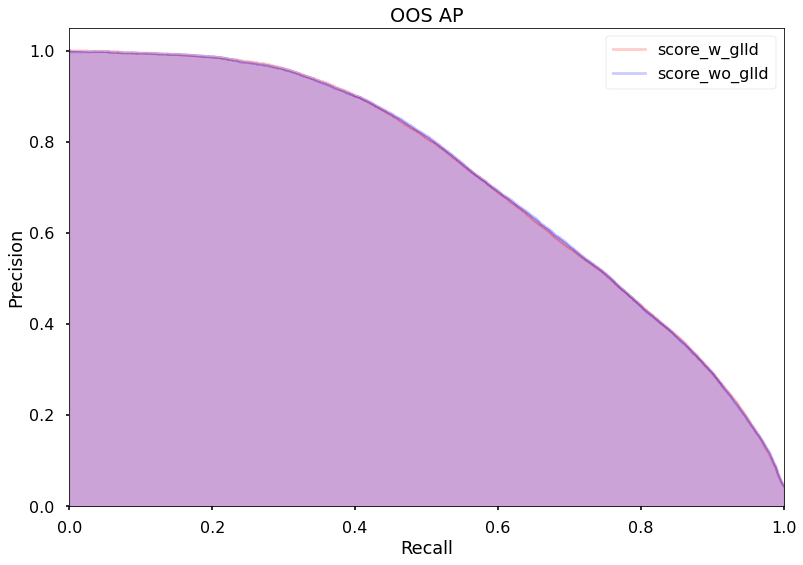

In [12]:
plot_pr_curve_mult(modeling_df['target'], scores, 'OOS AP', colors=['r', 'b'])

In [17]:
from sklearn.metrics import roc_auc_score, average_precision_score

auc = round(roc_auc_score(y_score=modeling_df['score_w_glld'], 
                          y_true=modeling_df['target'])*100, 2)
ap = round(average_precision_score(y_score=modeling_df['score_w_glld'], 
                                   y_true=modeling_df['target'])*100, 2)
print(f'score_w_glld - AP: {ap}, AUC: {auc}')

auc = round(roc_auc_score(y_score=modeling_df['score_wo_glld'], 
                          y_true=modeling_df['target'])*100, 2)
ap = round(average_precision_score(y_score=modeling_df['score_wo_glld'], 
                                   y_true=modeling_df['target'])*100, 2)
print(f'score_wo_glld - AP: {ap}, AUC: {auc}')

score_w_glld - AP: 71.92, AUC: 96.0
score_wo_glld - AP: 71.97, AUC: 96.02


### Risk Groups

In [32]:
def get_risk_groups(serie):
    return pd.cut(serie.round(), [300, 474, 510, 560, 600, 850], 
                  right=True, labels=[f'RG{i}' for i in range(1, 6)])

modeling_df['risk_group_w_glld'] = get_risk_groups(modeling_df.score_w_glld)
modeling_df['risk_group_wo_glld'] = get_risk_groups(modeling_df.score_wo_glld)

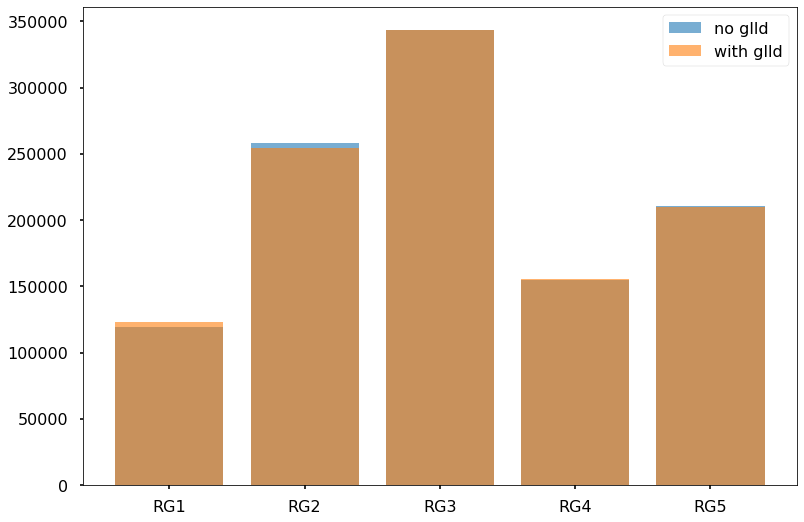

In [33]:
fig = plt.figure()
data = modeling_df.risk_group_w_glld.value_counts().sort_index()
plt.bar(data.index, data.values, alpha=0.6, label='no glld')
data = modeling_df.risk_group_wo_glld.value_counts().sort_index()
plt.bar(data.index, data.values, alpha=0.6, label='with glld')
plt.legend()
fig.savefig('../../artifacts/without-glld/comparison_score_stats/OOS/oos_risk_group_distr.png')

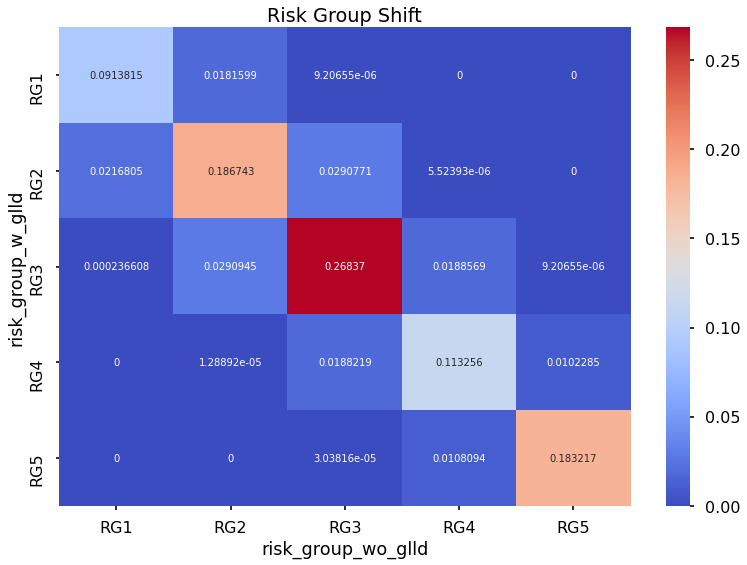

In [34]:
# compare the flow of risk groups
table = modeling_df[['risk_group_w_glld', 'risk_group_wo_glld']].value_counts(normalize=True).sort_index().reset_index()
table.columns = ['risk_group_w_glld', 'risk_group_wo_glld', 'counts']
table = pd.pivot_table(table, values='counts', index='risk_group_w_glld', 
                       columns='risk_group_wo_glld', fill_value=0)
fig = plt.figure()
sns.heatmap(table, cmap='coolwarm', annot=True, fmt='.6g')
plt.title('Risk Group Shift')
fig.savefig('../../artifacts/without-glld/comparison_score_stats/OOS/oos_RG_shift_norm.png')

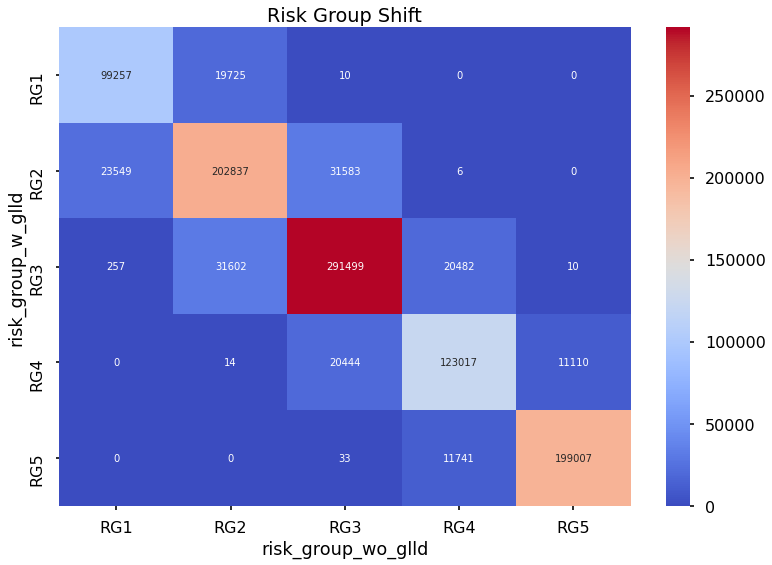

In [35]:
# compare the flow of risk groups
table = modeling_df[['risk_group_w_glld', 'risk_group_wo_glld']].value_counts().sort_index().reset_index()
table.columns = ['risk_group_w_glld', 'risk_group_wo_glld', 'counts']
table = pd.pivot_table(table, values='counts', index='risk_group_w_glld', 
                       columns='risk_group_wo_glld', fill_value=0)
fig = plt.figure()
sns.heatmap(table, cmap='coolwarm', annot=True, fmt='.6g')
plt.title('Risk Group Shift')
fig.savefig('../../artifacts/without-glld/comparison_score_stats/OOS/oos_RG_shift_raw.png')

### Statistic Tables

In [36]:
from rdsutils.plot import plot_pr_curve
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.metrics import classification_report, confusion_matrix
import gc

def build_table1(modeling_df, percentiles, target_col_name, pred_col_name):
    """ cumulative """
    df = []
    for thresh, pctl in [(np.percentile(modeling_df[pred_col_name], pctl), pctl) for pctl in percentiles]:
        pred = modeling_df[pred_col_name] >= thresh
        rep = classification_report(y_true=modeling_df[target_col_name], y_pred=pred, output_dict=True)
        conf = confusion_matrix(y_true=modeling_df[target_col_name], y_pred=pred)
        tn, fp, fn, tp = conf.ravel()
        df.append([pctl, thresh, fp / (fp + tn) * 100, rep['True']['recall'] * 100,
                  sum(conf[:, 1]), conf[1][1], conf[1][0], conf[0][1], tn])
    return pd.DataFrame(df, columns=['Percentile', 'Threshold', 'False Positive Rate (%)', 
                                     'Fraud Capture Rate (%)', '#Above Threshold', '#Fraudulent Above Threshold', 
                                     '#Fraudulent Below Threshold', '#Good Above Threshold', '#True Negatives'])

def get_metrics(df, score_col):
    dsigma = df[~df['fraud_score_2'].isna()]
    auc = round(roc_auc_score(y_score=dsigma['fraud_score_2'], 
                              y_true=dsigma['target'])*100, 2)
    ap = round(average_precision_score(y_score=dsigma['fraud_score_2'], 
                                       y_true=dsigma['target'])*100, 2)

    print(f'fraud_score_2 alone: {auc}, {ap}')
    del dsigma
    gc.collect()

    dfico = df[~df['fico_score'].isna()]
    auc = round(roc_auc_score(y_score=850-dfico['fico_score'], 
                              y_true=dfico['target'])*100, 2)
    ap = round(average_precision_score(y_score=850-dfico['fico_score'], 
                                       y_true=dfico['target'])*100, 2)

    print(f'fico alone: {auc}, {ap}')
    del dfico
    gc.collect()

    auc = round(roc_auc_score(y_score=df[score_col], 
                              y_true=df['target'])*100, 2)
    ap = round(average_precision_score(y_score=df[score_col], 
                                       y_true=df['target'])*100, 2)

    print(f'model perf: {auc}, {ap}')

#### OOS Stats

In [37]:
get_metrics(modeling_df, 'pred_w_glld')

fraud_score_2 alone: 75.15, 18.89
fico alone: 50.91, 10.79
model perf: 96.0, 71.92


In [38]:
get_metrics(modeling_df, 'pred_wo_glld')

fraud_score_2 alone: 75.15, 18.89
fico alone: 50.91, 10.79
model perf: 96.02, 71.97


#### OOS Tables

In [18]:
table = build_table1(modeling_df, np.linspace(90, 99, 10), 'target', 'pred_wo_glld').round(2)
display(table)
print(table.to_csv(index=False))

,Percentile,Threshold,False Positive Rate (%),Fraud Capture Rate (%),#Above Threshold,#Fraudulent Above Threshold,#Fraudulent Below Threshold,#Good Above Threshold,#True Negatives
0,90.0,0.63,6.51,84.56,108619,41118,7509,67501,970055
1,91.0,0.68,5.57,82.25,97757,39998,8629,57759,979797
2,92.0,0.73,4.64,79.61,86895,38710,9917,48185,989371
3,93.0,0.77,3.75,76.45,76033,37174,11453,38859,998697
4,94.0,0.82,2.89,72.43,65171,35222,13405,29949,1007607
5,95.0,0.86,2.07,67.42,54310,32782,15845,21528,1016028
6,96.0,0.89,1.34,60.84,43448,29586,19041,13862,1023694
7,97.0,0.93,0.68,52.49,32586,25523,23104,7063,1030493
8,98.0,0.96,0.21,40.19,21724,19542,29085,2182,1035374
9,99.0,0.99,0.02,21.94,10862,10671,37956,191,1037365


Percentile,Threshold,False Positive Rate (%),Fraud Capture Rate (%),#Above Threshold,#Fraudulent Above Threshold,#Fraudulent Below Threshold,#Good Above Threshold,#True Negatives
90.0,0.63,6.51,84.56,108619,41118,7509,67501,970055
91.0,0.68,5.57,82.25,97757,39998,8629,57759,979797
92.0,0.73,4.64,79.61,86895,38710,9917,48185,989371
93.0,0.77,3.75,76.45,76033,37174,11453,38859,998697
94.0,0.82,2.89,72.43,65171,35222,13405,29949,1007607
95.0,0.86,2.07,67.42,54310,32782,15845,21528,1016028
96.0,0.89,1.34,60.84,43448,29586,19041,13862,1023694
97.0,0.93,0.68,52.49,32586,25523,23104,7063,1030493
98.0,0.96,0.21,40.19,21724,19542,29085,2182,1035374
99.0,0.99,0.02,21.94,10862,10671,37956,191,1037365



In [19]:
table = build_table1(modeling_df, np.linspace(0, 90, 10), 'target', 'pred_wo_glld').round(2)
display(table)
print(table.to_csv(index=False))

,Percentile,Threshold,False Positive Rate (%),Fraud Capture Rate (%),#Above Threshold,#Fraudulent Above Threshold,#Fraudulent Below Threshold,#Good Above Threshold,#True Negatives
0,0.0,0.00,100.00,100.00,1086183,48627,0,1037556,0
1,10.0,0.01,89.54,99.81,977564,48537,90,929027,108529
2,20.0,0.01,79.08,99.61,868946,48439,188,820507,217049
3,30.0,0.02,68.62,99.40,760328,48333,294,711995,325561
4,40.0,0.02,58.17,99.15,651710,48215,412,603495,434061
5,50.0,0.04,47.71,98.83,543092,48058,569,495034,542522
6,60.0,0.06,37.27,98.23,434473,47768,859,386705,650851
7,70.0,0.11,26.86,96.96,325855,47150,1477,278705,758851
8,80.0,0.25,16.53,94.01,217237,45715,2912,171522,866034
9,90.0,0.63,6.51,84.56,108619,41118,7509,67501,970055


Percentile,Threshold,False Positive Rate (%),Fraud Capture Rate (%),#Above Threshold,#Fraudulent Above Threshold,#Fraudulent Below Threshold,#Good Above Threshold,#True Negatives
0.0,0.0,100.0,100.0,1086183,48627,0,1037556,0
10.0,0.01,89.54,99.81,977564,48537,90,929027,108529
20.0,0.01,79.08,99.61,868946,48439,188,820507,217049
30.0,0.02,68.62,99.4,760328,48333,294,711995,325561
40.0,0.02,58.17,99.15,651710,48215,412,603495,434061
50.0,0.04,47.71,98.83,543092,48058,569,495034,542522
60.0,0.06,37.27,98.23,434473,47768,859,386705,650851
70.0,0.11,26.86,96.96,325855,47150,1477,278705,758851
80.0,0.25,16.53,94.01,217237,45715,2912,171522,866034
90.0,0.63,6.51,84.56,108619,41118,7509,67501,970055



In [20]:
table = build_table1(modeling_df, np.linspace(0, 99, 100), 'target', 'pred_wo_glld').round(2)
display(table)
print(table.to_csv(index=False))

,Percentile,Threshold,False Positive Rate (%),Fraud Capture Rate (%),#Above Threshold,#Fraudulent Above Threshold,#Fraudulent Below Threshold,#Good Above Threshold,#True Negatives
0,0.0,0.00,100.00,100.00,1086183,48627,0,1037556,0
1,1.0,0.00,98.95,99.99,1075321,48620,7,1026701,10855
2,2.0,0.00,97.91,99.98,1064459,48615,12,1015844,21712
3,3.0,0.00,96.86,99.95,1053597,48604,23,1004993,32563
4,4.0,0.00,95.82,99.94,1042735,48598,29,994137,43419
...,...,...,...,...,...,...,...,...,...
95,95.0,0.86,2.07,67.42,54310,32782,15845,21528,1016028
96,96.0,0.89,1.34,60.84,43448,29586,19041,13862,1023694
97,97.0,0.93,0.68,52.49,32586,25523,23104,7063,1030493
98,98.0,0.96,0.21,40.19,21724,19542,29085,2182,1035374


Percentile,Threshold,False Positive Rate (%),Fraud Capture Rate (%),#Above Threshold,#Fraudulent Above Threshold,#Fraudulent Below Threshold,#Good Above Threshold,#True Negatives
0.0,0.0,100.0,100.0,1086183,48627,0,1037556,0
1.0,0.0,98.95,99.99,1075321,48620,7,1026701,10855
2.0,0.0,97.91,99.98,1064459,48615,12,1015844,21712
3.0,0.0,96.86,99.95,1053597,48604,23,1004993,32563
4.0,0.0,95.82,99.94,1042735,48598,29,994137,43419
5.0,0.0,94.77,99.92,1031873,48589,38,983284,54272
6.0,0.0,93.72,99.91,1021013,48585,42,972428,65128
7.0,0.0,92.68,99.88,1010150,48571,56,961579,75977
8.0,0.0,91.63,99.86,999288,48561,66,950727,86829
9.0,0.01,90.59,99.83,988426,48545,82,939881,97675
10.0,0.01,89.54,99.81,977564,48537,90,929027,108529
11.0,0.01,88.49,99.79,966702,48525,102,918177,119379
12.0,0.01,87.45,99.79,955841,48524,103,907317,130239
13.0,0.01,86.4,99.78,944979,48519,108,896460,141096
14.0,0.01,85.36,99.76,934117,48511,116,885606,151950
15.0,0.01,84.31,99.75,923255,48504,123,874751,162805
16.0,0.0